In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime, timedelta
from scipy.stats import qmc

from bo_methods_lib.GP_Vs_True_Sensitivity import Compare_GP_True_Movie
from bo_methods_lib.scikit_gpytorch_debug import scikit_gpytorch_mul_maps
# from bo_methods_lib.GP_Validation import LOO_Analysis
from bo_methods_lib.bo_functions_generic import round_time, gen_theta_set,gen_x_set, find_train_doc_path, set_ep, clean_1D_arrays

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Set Date and Time
dateTimeObj = round_time()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M")
print(DateTime)
# DateTime = "2022/11/29/09-48"
DateTime = None ##For Testing

Date and Time:  24-Apr-2023 (14:15:00)
2023/04/24/14-15


In [3]:
#Set Parameters
#Need to run at a and b, need 2 arrays to test that this will work
CS = 2.2

Bound_Cut = True
denseX = True
eval_Train = True

Constants = np.array([[-200,-100,-170,15],
                      [-1,-1,-6.5,0.7],
                      [0,0,11,0.6],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]])
if CS == 2.2:
    skip_param_types = 1 #This is what changes for subpoint
    true_p = Constants[skip_param_types:skip_param_types+2].flatten()
    param_dict = {0 : 'a_1', 1 : 'a_2', 2 : 'a_3', 3 : 'a_4',
                  4 : 'b_1', 5 : 'b_2', 6 : 'b_3', 7 : 'b_4'}
    exp_d = 2
    if Bound_Cut == True:
        bounds_x = np.array([[-1.0, 0.0],
                            [   0.5, 1.5]])
        if denseX == True:
            n = 30
        else:
            n = 25 #Number of experimental data points to use
    else:    
        bounds_x = np.array([[-1.5, -0.5],
                     [   1,    2]])
        n = 27 #Number of experimental data points to use
    bounds_p = np.array([[-2, -2, -10, -2, -2, -2,  5, -2],
                   [ 2,  2,   0,  2,  2,  2, 15,  2]])

else:
    Constants = true_p = np.array([1,-1])
    skip_param_types = 0
    param_dict = {0 : '\\theta_1', 1 : '\\theta_2'}
    exp_d = 1
    n = 5
    bounds_x = np.array([[-2], [2]])
    bounds_p = np.array([[-2, -2],
                         [ 2,  2]])

# print(Theta_True)
t = 20
# percentiles = np.linspace(-1.0,1.0,41)
percentiles = np.linspace(0,0,1)
d = len(true_p)
kernel_func = ["Mat_52"]
package = "scikit_learn"
train_iter = 300
initialize = 1
noise_std = 1e-7
outputscl = False
set_lengthscale = np.linspace(1e-6,1.0,2)
set_lengthscale = [1]
verbose = False
norm = False

obj = "obj"

emulator =  True
# save_figure = True
save_figure = False
save_csvs = False

if Bound_Cut == True:
    cut_bounds = '_cut_bounds'
else:
    cut_bounds = ""
    
if denseX == True:
    dense = "_dense"
else:
    dense = ""

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/d='+str(exp_d)+'/n='+str(n)+cut_bounds+dense+'.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1:exp_d+1]
Yexp = exp_data[:,-1]

Xexp = clean_1D_arrays(Xexp)

#Define GP Testing space
p=20
# print(bounds_x)
X_space = gen_x_set(LHS = False, n_points = p, dimensions = exp_d, bounds = bounds_x)
# print(X_space[-5:,:])

In [4]:
%%time
#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M")
DateTime = None ##For Testing
print("Date and Time Saved: ", DateTime)

t_use = int(t*n)
all_data_doc = find_train_doc_path(emulator, obj, d, t_use, Bound_Cut, denseX)
print(all_data_doc)
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))

Date and Time:  24-Apr-2023 (14:12:33)
Date and Time Saved:  None
Input_CSVs/Train_Data/d=8/all_emul_data/t=600_cut_bounds_dense.csv
CPU times: user 3.71 ms, sys: 1.11 ms, total: 4.82 ms
Wall time: 3.55 ms


Lengthscale ['3.129e-01', '2.082e+00', '1.215e+01', '4.514e+00', '1.093e+01', '9.522e+00', '5.722e+00', '6.355e+00', '1.563e-01', '2.114e-01']
Noise for lengthscale 1.000e-14
Outputscale 4.813e+00
Base Theta Train for Movies: [-1.17405  -1.657363 -9.801574 -1.555507  0.656785  0.016924 14.569803
 -0.183648]
MAPE:  0.00838524854108049


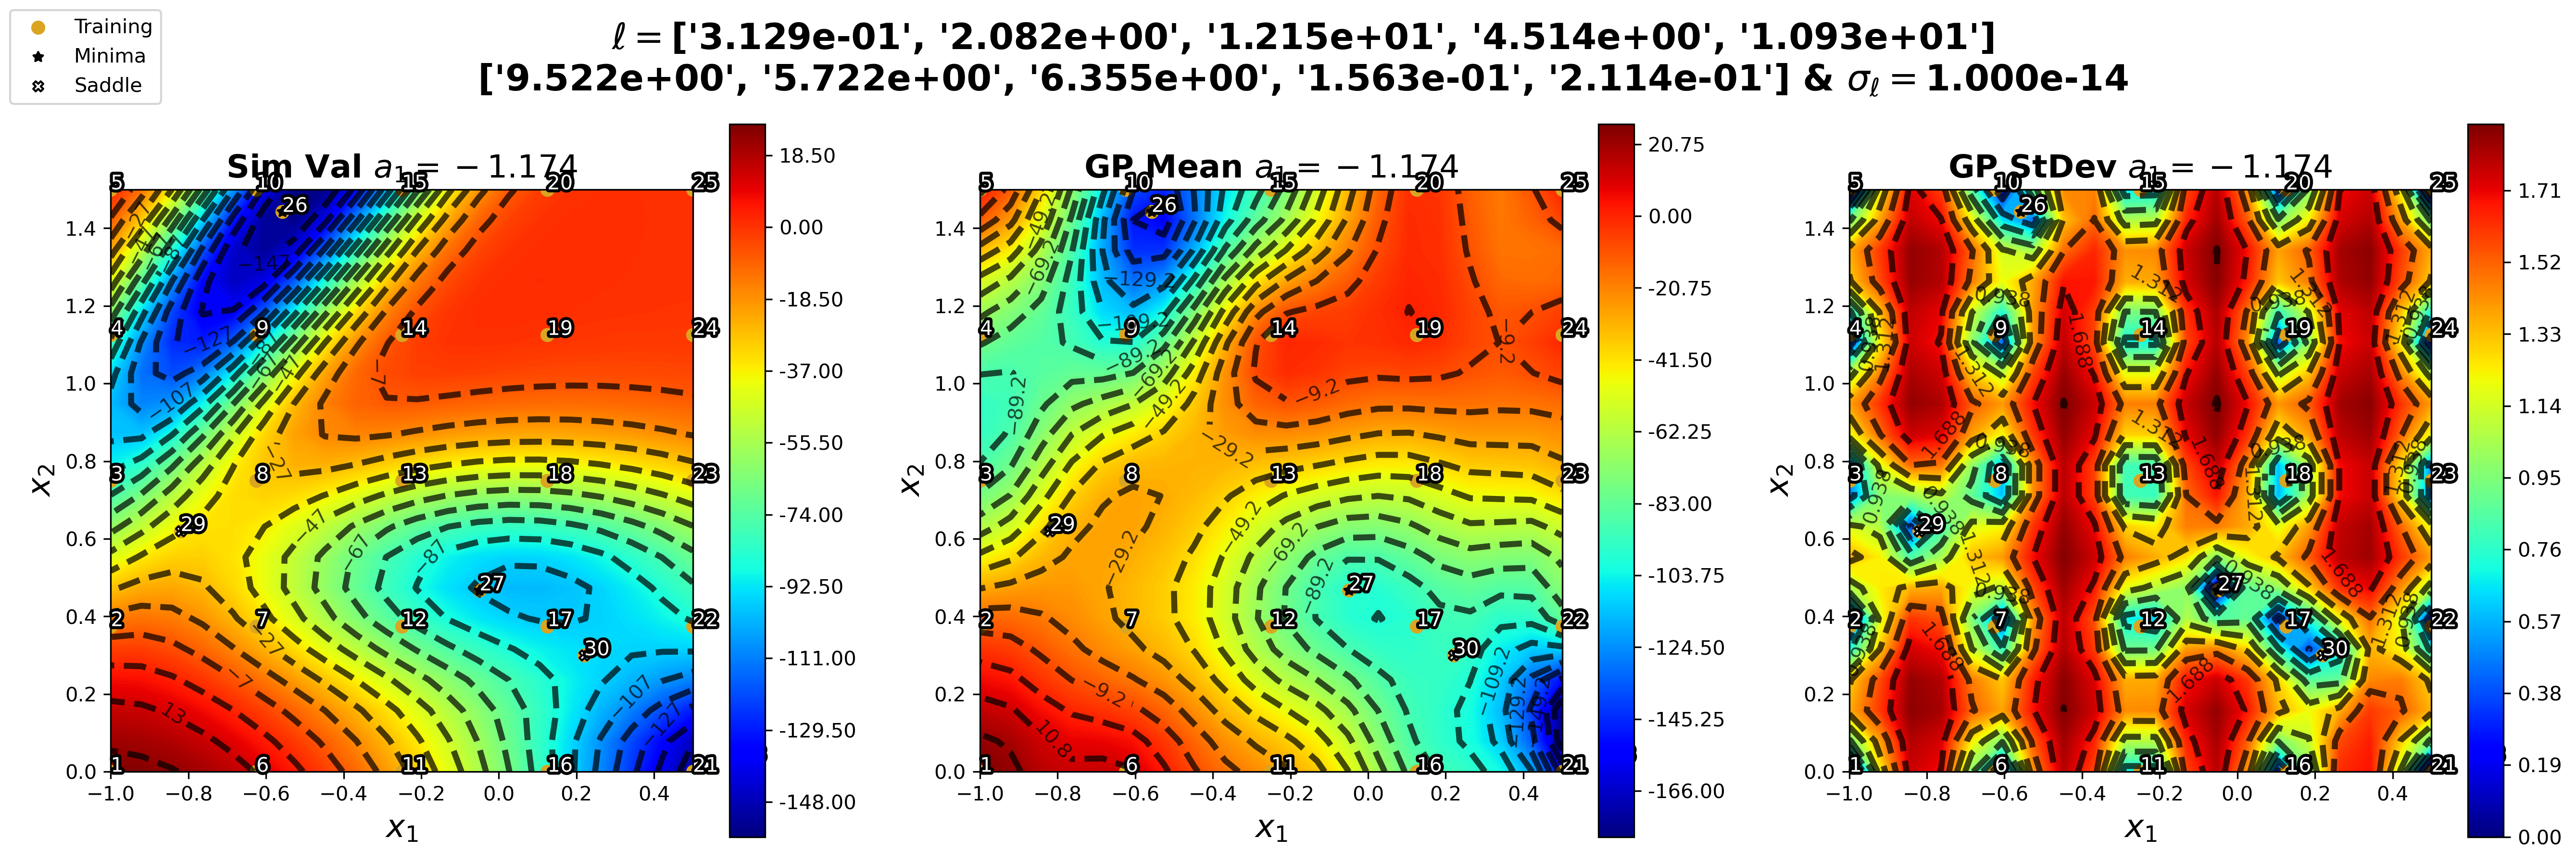

In [5]:
outputscl = True
set_lengthscale = [None]
package = "gpytorch"
for set_lengthscl in set_lengthscale:
    for kernel in kernel_func:        
        scikit_gpytorch_mul_maps(all_data, X_space, Xexp, Yexp, Constants, true_p, CS, 
                              bounds_p, percentiles, skip_param_types, kernel, set_lengthscl, 
                              outputscl, train_iter, initialize, noise_std, verbose, DateTime, save_csvs, 
                              save_figure, eval_Train, Bound_Cut, package = package)